### **Approach 0 – Baseline Dictionary Approach**
Rule-based error correction using a predefined medical dictionary.

In [1]:
!pip uninstall spacy pydantic typer -y
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz

Found existing installation: spacy 3.4.4
Uninstalling spacy-3.4.4:
  Successfully uninstalled spacy-3.4.4
Found existing installation: pydantic 1.10.22
Uninstalling pydantic-1.10.22:
  Successfully uninstalled pydantic-1.10.22
Found existing installation: typer 0.7.0
Uninstalling typer-0.7.0:
  Successfully uninstalled typer-0.7.0
  Using cached spacy-3.7.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (27 kB)
  Using cached thinc-8.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (15 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 6.2 MB/s eta 0:00:00
Using cached spacy-3.7.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.8/444.8 kB 17.0 MB/s eta 0:00:00
Using cached thinc-8.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (920 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: thinc
    Fo

In [2]:
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz

  Using cached spacy-3.7.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (27 kB)
  Using cached thinc-8.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (15 kB)
Using cached spacy-3.7.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.6 MB)
Using cached thinc-8.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (920 kB)
  Attempting uninstall: thinc
    Found existing installation: thinc 8.1.12
    Uninstalling thinc-8.1.12:
      Successfully uninstalled thinc-8.1.12
  Attempting uninstall: spacy
    Found existing installation: spacy 3.4.4
    Uninstalling spacy-3.4.4:
      Successfully uninstalled spacy-3.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-ner-bc5cdr-md 0.5.1 requires spacy<3.5.0,>=3.4.1, but you have spacy 3.7.5 which is incompatible.
  Using cached https://s3-us-west

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter, defaultdict
from difflib import SequenceMatcher
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5ForConditionalGeneration, T5Tokenizer
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk
from tqdm.notebook import tqdm
import spacy

In [4]:
# Ensure NLTK and spaCy resources are downloaded
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

import spacy
# Download spaCy model
try:
    spacy.load('en_core_web_sm')
except:
    spacy.cli.download('en_core_web_sm')
nlp = spacy.load('en_core_web_sm')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/usr/local/lib/python3.11/dist-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8 and may not be 100% compatible with the current version (3.4.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Using device: cuda


In [5]:
# Load the dataset
file_name = "/content/drive/MyDrive/ASR/Spell_Correction_for_ASR_Noun_Enhancement_assignment_dataset.xlsx"

# Load the dataset from Excel
df = pd.read_excel(file_name, sheet_name="Sheet1")

# Drop any rows with missing values
df.dropna(inplace=True)

In [6]:
# 1.1 Dataset Structure Analysis
print("--- Dataset Head ---")
print(df.head())
print("\n--- Dataset Info ---")
print(df.info())

--- Dataset Head ---
                                   correct sentences  \
0  It is important to follow your doctor's instru...   
1  It's important to follow the prescribed dosage...   
2  "Improve your quality of life with CARTIGEN FO...   
3  Nadolol is a beta-blocker medicine commonly pr...   
4  Remember to take EZOFIN PLUS regularly as pres...   

              ASR-generated incorrect transcriptions  
0  It is important to follow your doctor's instru...  
1  It's important to follow the prescribed dosage...  
2  Improve your quality of life with Cartagan For...  
3  Natilol is a beta-blocker medicine commonly pr...  
4  Remember to take Ezefin Plus regularly as pres...  

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   correct sentences                       10

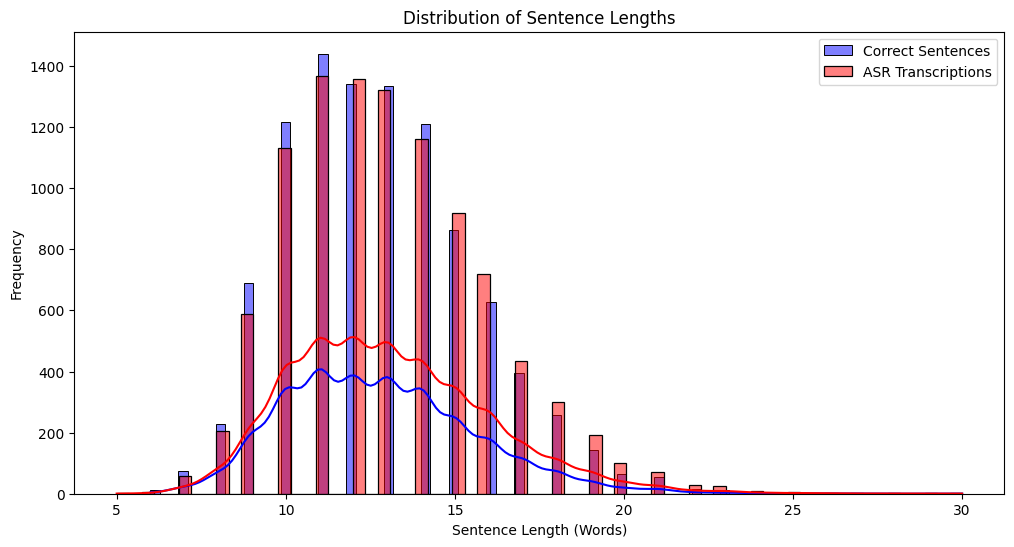

In [7]:
# 1.2 Analyze Sentence Lengths
df['correct_len'] = df['correct sentences'].apply(lambda x: len(x.split()))
df['asr_len'] = df['ASR-generated incorrect transcriptions'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(df['correct_len'], color='blue', label='Correct Sentences', kde=True)
sns.histplot(df['asr_len'], color='red', label='ASR Transcriptions', kde=True)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length (Words)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [8]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz

import re
import spacy
from collections import defaultdict
from difflib import SequenceMatcher

# --- Load models ---
# Biomedical NER (CHEMICAL, DISEASE)
nlp_med = spacy.load("en_ner_bc5cdr_md")

# Optional: a small English model for POS tags. If you don't have it, comment these two lines
try:
    nlp_pos = spacy.load("en_core_web_sm")
except Exception:
    nlp_pos = None  # POS will fall back to False if model not available

# Quick sanity check (you can comment these prints later)
# print("med model:", nlp_med.meta.get("name"), "pipes:", nlp_med.pipe_names)
# if nlp_pos: print("pos model:", nlp_pos.meta.get("name"), "pipes:", nlp_pos.pipe_names)

MED_LABELS = {"CHEMICAL", "DISEASE"}
DRUG_SUFFIXES = (
    "olol","pril","sartan","dipine","statin","azole","cycline","cillin","mycin",
    "mab","xaban","parin","afil","setron","caine","dronate","prazole","gliptin",
    "gliflozin","glitazone","pramide","pramine","tidine","tadine","zosin","terol",
)

def clean_span(text: str) -> str:
    # Normalize whitespace and strip surrounding punctuation that can break NER
    t = re.sub(r"\s+", " ", text)
    return t.strip(" \t\n\r-–—.,;:!?()[]{}'\"“”‘’")

def is_medical_term(text: str) -> bool:
    if not text:
        return False
    span = clean_span(text)
    if not span:
        return False
    # Biomedical NER first
    doc = nlp_med(span)
    if any(ent.label_ in MED_LABELS for ent in doc.ents):
        return True
    # Fallback suffix heuristic on tokens
    cleaned = re.sub(r"[^A-Za-z\- ]", " ", span).lower()
    for tok in cleaned.split():
        if any(tok.endswith(suf) for suf in DRUG_SUFFIXES):
            return True
    return False

def is_noun_phrase(text: str) -> bool:
    if not text or nlp_pos is None:
        return False
    doc = nlp_pos(text)
    return any(tok.pos_ in ("NOUN", "PROPN") for tok in doc)

# 1.3 Build the Error Dictionary (no duplicate corrections per key, robust medical detection)
def build_error_dictionary(correct_sentences, asr_sentences):
    error_dict = defaultdict(list)

    for correct_s, asr_s in zip(correct_sentences, asr_sentences):
        # Use biomedical tokenizer for consistent tokenization; keep BOTH raw and lower variants
        correct_doc = nlp_med(correct_s)
        asr_doc = nlp_med(asr_s)

        correct_tokens_lower = [t.text.lower() for t in correct_doc]
        asr_tokens_lower = [t.text.lower() for t in asr_doc]

        correct_tokens_raw = [t.text for t in correct_doc]
        asr_tokens_raw = [t.text for t in asr_doc]

        sm = SequenceMatcher(None, asr_tokens_lower, correct_tokens_lower)

        for tag, i1, i2, j1, j2 in sm.get_opcodes():
            if tag in ("replace", "delete", "insert"):
                # Incorrect phrase (key) in lower for stability
                incorrect_phrase = " ".join(asr_tokens_lower[i1:i2]).strip()
                # Correction shown in original casing for readability & better NER/POS
                correct_phrase = " ".join(correct_tokens_raw[j1:j2]).strip()

                if incorrect_phrase and correct_phrase:
                    # Detect medical on the CLEAN, original-cased correction
                    med_correct = is_medical_term(correct_phrase)
                    # (Optional) Also check the incorrect phrase (helps with near-miss meds)
                    med_incorrect = is_medical_term(" ".join(asr_tokens_raw[i1:i2]).strip())

                    is_medical = med_correct or med_incorrect
                    is_noun = is_noun_phrase(correct_phrase)

                    entry = {
                        "correction": correct_phrase,
                        "is_noun": is_noun,
                        "is_medical": is_medical,
                    }
                    if entry not in error_dict[incorrect_phrase]:
                        error_dict[incorrect_phrase].append(entry)

    return error_dict

  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz (120.2 MB)
  Preparing metadata (setup.py) ... done


In [9]:
# Build dictionary
error_dictionary = build_error_dictionary(
    df['correct sentences'],
    df['ASR-generated incorrect transcriptions']
)

In [10]:
# Display example entries
print("\n--- Example Error Dictionary Entries ---")
for key, value_list in list(error_dictionary.items())[:20]:
    for value in value_list:
        print(f"Incorrect: '{key}' -> Correct: '{value['correction']}', "
              f"Is Noun: {value['is_noun']}, Is Medical: {value['is_medical']}")


--- Example Error Dictionary Entries ---
Incorrect: 'amlodat' -> Correct: 'AMLOT-AT', Is Noun: True, Is Medical: False
Incorrect: 'nucides , b' -> Correct: 'NUSAID-SP', Is Noun: True, Is Medical: False
Incorrect: 'cartagan' -> Correct: 'CARTIGEN', Is Noun: False, Is Medical: False
Incorrect: 'natilol' -> Correct: 'Nadolol', Is Noun: True, Is Medical: True
Incorrect: 'ezefin' -> Correct: 'EZOFIN', Is Noun: True, Is Medical: False
Incorrect: 'bicaulforte' -> Correct: 'Becowel Forte', Is Noun: True, Is Medical: False
Incorrect: 'diosido' -> Correct: 'Diocid-o', Is Noun: True, Is Medical: False
Incorrect: 'calgro xt' -> Correct: 'Calgrow-xt', Is Noun: True, Is Medical: False
Incorrect: 'kayser' -> Correct: 'KAYZURE', Is Noun: True, Is Medical: False
Incorrect: 'hiclate' -> Correct: 'hyclate', Is Noun: False, Is Medical: True
Incorrect: 'beta-cycloxtrin' -> Correct: 'betacyclodextrin', Is Noun: False, Is Medical: True
Incorrect: 'brotelium toxelate' -> Correct: 'Bretylium tosylate', Is Nou

In [11]:
def correct_with_dictionary(sentence, error_dict):
    doc = nlp(sentence.lower())
    corrected_tokens = []
    i = 0
    while i < len(doc):
        corrected = False
        # Check for multi-word phrases first
        for j in range(len(doc), i, -1):
            phrase = " ".join([token.text for token in doc[i:j]])
            if phrase in error_dict:
                # Use the first correction in the list
                first_correction = error_dict[phrase][0]['correction']
                corrected_tokens.append(first_correction)
                i = j
                corrected = True
                break
        if not corrected:
            corrected_tokens.append(doc[i].text)
            i += 1
    return " ".join(corrected_tokens)

In [13]:
df.head()

,correct sentences,ASR-generated incorrect transcriptions,correct_len,asr_len
0,It is important to follow your doctor's instru...,It is important to follow your doctor's instru...,12,12
1,It's important to follow the prescribed dosage...,It's important to follow the prescribed dosage...,12,13
2,"""Improve your quality of life with CARTIGEN FO...",Improve your quality of life with Cartagan For...,14,14
3,Nadolol is a beta-blocker medicine commonly pr...,Natilol is a beta-blocker medicine commonly pr...,10,10
4,Remember to take EZOFIN PLUS regularly as pres...,Remember to take Ezefin Plus regularly as pres...,17,17


In [12]:
# Example of baseline correction
example_asr = df['ASR-generated incorrect transcriptions'].iloc[1]
example_corrected = correct_with_dictionary(example_asr, error_dictionary)
print(f"\n--- Baseline Model Example ---")
print(f"ASR Input: {example_asr}")
print(f"Corrected: {example_corrected}")
print(f"Ground Truth: {df['correct sentences'].iloc[1]}")


--- Baseline Model Example ---
ASR Input: It's important to follow the prescribed dosage of Nucides, B for optimal results.
Corrected: it ’s important to follow the prescribed dosage of NUSAID-SP for optimal results !
Ground Truth: It's important to follow the prescribed dosage of NUSAID-SP for optimal results.


In [21]:
# Helper function for dictionary-based correction
def evaluate_baseline(test_df):
    correct_sentences = test_df['correct sentences'].tolist()
    asr_transcriptions = test_df['ASR-generated incorrect transcriptions'].tolist()

    predictions = [correct_with_dictionary(asr_text, error_dictionary) for asr_text in asr_transcriptions]

    total_words, correct_words, total_chars, correct_chars, total_nouns, correct_nouns = 0,0,0,0,0,0
    bleu_scores = []

    for pred, correct in zip(predictions, correct_sentences):
        pred_tokens = pred.split()
        correct_tokens = correct.split()

        total_words += len(correct_tokens)
        correct_words += sum(1 for p, c in zip(pred_tokens, correct_tokens) if p == c)

        total_chars += len(correct)
        correct_chars += sum(1 for p, c in zip(pred, correct) if p == c)

        bleu_scores.append(sentence_bleu([correct_tokens], pred_tokens, smoothing_function=SmoothingFunction().method1))

        correct_doc = nlp(correct)
        pred_doc = nlp(pred)
        correct_nouns_pos = [token.text for token in correct_doc if token.pos_ in ['NOUN','PROPN']]
        pred_nouns_pos = [token.text for token in pred_doc if token.pos_ in ['NOUN','PROPN']]

        total_nouns += len(correct_nouns_pos)
        correct_nouns += sum(1 for p, c in zip(pred_nouns_pos, correct_nouns_pos) if p == c)

    return {
        "word_accuracy": correct_words / total_words if total_words > 0 else 0,
        "char_accuracy": correct_chars / total_chars if total_chars > 0 else 0,
        "bleu_score": np.mean(bleu_scores),
        "noun_accuracy": correct_nouns / total_nouns if total_nouns > 0 else 0,
        "predictions": predictions
    }

# Example usage
baseline_results = evaluate_baseline(test_df)
print("\n--- Baseline Model Results ---")
print(f"Word Accuracy: {baseline_results['word_accuracy']:.4f}")
print(f"Char Accuracy: {baseline_results['char_accuracy']:.4f}")
print(f"BLEU Score: {baseline_results['bleu_score']:.4f}")
print(f"Noun Accuracy: {baseline_results['noun_accuracy']:.4f}")


--- Baseline Model Results ---
Word Accuracy: 0.4949
Char Accuracy: 0.4367
BLEU Score: 0.5569
Noun Accuracy: 0.4453


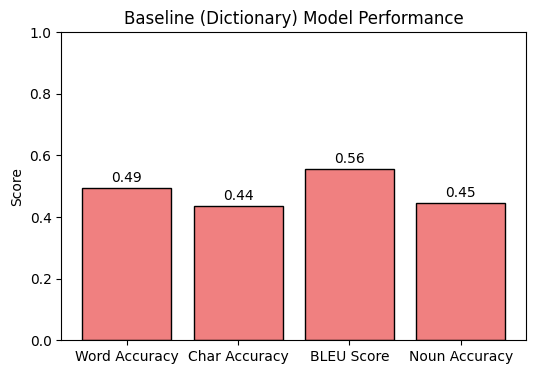

In [1]:
import matplotlib.pyplot as plt

# Baseline results
baseline_metrics = {
    "Word Accuracy": 0.4949,
    "Char Accuracy": 0.4367,
    "BLEU Score": 0.5569,
    "Noun Accuracy": 0.4453
}

plt.figure(figsize=(6,4))
plt.bar(baseline_metrics.keys(), baseline_metrics.values(), color="lightcoral", edgecolor="black")

# Labels
plt.ylabel("Score")
plt.ylim(0,1)
plt.title("Baseline (Dictionary) Model Performance")

# Annotate values
for i, (metric, value) in enumerate(baseline_metrics.items()):
    plt.text(i, value+0.02, f"{value:.2f}", ha="center", fontsize=10)

plt.show()
